In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from linear_regression_tf import LinearRegressionTF
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf

In [2]:
tf.enable_eager_execution()

# Conversion functions for various columns

In [3]:
def parse_commision(commision):
    if commision.strip() == '':
        return float('nan')
    try:
        return re.match(r'\D*(\d+)\D*', commision).group(1)
    except:
        return float('nan')

In [4]:
def parse_number(value):
    try:
        return float(value)
    except:
        return float('NaN')

In [5]:
def parse_surface(char):
    char = char.replace('.', '')
    char = char.replace(',', '.')
    if 'mp' in char:
        try:
            return float(re.match(r'\D*(\d+\.?\d+)\s*mp.*', char).group(1))
        except:
            pass
    return float('NaN')

In [6]:
def parse_year(char):
    try:
        return int(re.match(r'\D*(\d+)\D*', char).group(1))
    except:
        return float('nan')

In [7]:
def parse_floor(char):
    if 'parter' in char.lower():
        floor = 0
    elif 'etaj' in char.lower():
        try:
            return int(re.match(r'.*etaj\s*(\d+)', char.lower()).group(1))
        except:
            return float('nan')

In [8]:
def map_compartimentalization(comp):
    try:
        return {
        'decomandat': 0,
        'semidecomandat': 1,
        'nedecomandat': 2,
        'circular': 3,
        'vagon': 4
        }[comp]
    except:
        return 5

In [9]:
def map_comfort(comf):
    if comf == 'lux':
        return 4
    return float(comf)

In [10]:
def map_balconies(balc):
    if type(balc) is float:
        return balc
    if 'închise' not in balc:
        return float(balc)
    else:
        return -int(re.match(r'.*(\d+).*închise', balc).group(1))

In [11]:
def map_structure(structure):
    try:
        return {
            'caramida': 1,
            'altele': 0,
            'metal': 2,
            'bca': 3,
            'beton': 4,
            'lemn': 5
        }[structure]
    except Exception as e:
        return float('nan')

In [12]:
def map_type(t):
    if t == 'bloc de apartamente':
        return 1
    elif t == 'casa/vila':
        return 2
    else:
        return 0

In [13]:
def parse_price(price):
    price = price.replace('.', '')
    price = price.replace(',', '')
    try:
        return float(price)
    except:
        return float('nan')

# Constructing the DataFrame

In [14]:
data = []
with open('dataset.txt', 'rt') as fin:
    for line in fin:
        d = json.loads(line)
        if 'An construcţie:' in d:
            d['An construcţie:'] = parse_year(d['An construcţie:'])
        if 'Etaj:' in d:
            d['Etaj:'] = parse_floor(d['Etaj:'])
        if 'Suprafaţă construită:' in d:
            d['Suprafaţă construită:'] = parse_surface(d['Suprafaţă construită:'])
        if 'Suprafaţă utilă totală:' in d:
            d['Suprafaţă utilă totală:'] = parse_surface(d['Suprafaţă utilă totală:'])
        if 'Suprafaţă utilă:' in d:
            d['Suprafaţă utilă:'] = parse_surface(d['Suprafaţă utilă:'])
        del d['currency']
        data.append(d)

In [15]:
df = pd.DataFrame.from_records(data)
df

,An construcţie:,Compartimentare:,Confort:,Etaj:,Nr. balcoane:,Nr. bucătării:,Nr. băi:,Nr. camere:,Nr. garaje:,Nr. locuri parcare:,...,Suprafaţă utilă:,Tip imobil:,commission,description,details,dist_underground,location,poi,price,specifications
0,2017.0,decomandat,lux,4.0,NaN,1,2,4,1,NaN,...,125.00,bloc de apartamente,Comision 0%,"Amplasat in zona premium nord, langa Parcul He...",https://www.imobiliare.ro/vanzare-apartamente/...,1250 m (16 minute),"Bucuresti, zona Herastrau",Localizare şi împrejurimi\nLocalizare\nStreetV...,300.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
1,2019.0,decomandat,lux,2.0,2,1,2,3,1,56,...,86.63,bloc de apartamente,Comision 0%,La GLOIRE Parc du LAC este al doilea concept r...,https://www.imobiliare.ro/vanzare-apartamente/...,,"Bucuresti, zona Baneasa",Localizare şi împrejurimi\nLocalizare\nStreetV...,100.999,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
2,2019.0,decomandat,lux,NaN,2,1,2,3,1,56,...,111.97,bloc de apartamente,Comision 0%,La GLOIRE Parc du LAC este al doilea concept r...,https://www.imobiliare.ro/vanzare-apartamente/...,,"Bucuresti, zona Pipera",Localizare şi împrejurimi\nLocalizare\nStreetV...,102.999,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
3,2019.0,semidecomandat,1,1.0,1,1,2,3,NaN,NaN,...,71.85,bloc de apartamente,Comision 0%,Cu aproape 20% din unitati vandute in primele ...,https://www.imobiliare.ro/vanzare-apartamente/...,940 m (12 minute),"Bucuresti, Sector 1, zona Aviatiei",Localizare şi împrejurimi\nLocalizare\nStreetV...,83.200,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
4,2019.0,decomandat,1,1.0,1,1,2,2,NaN,NaN,...,52.61,bloc de apartamente,Comision 0%,Cu aproape 20% din unitati vandute in primele ...,https://www.imobiliare.ro/vanzare-apartamente/...,970 m (12 minute),"Bucuresti, Sector 1, zona Pipera",Localizare şi împrejurimi\nLocalizare\nStreetV...,64.072,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
5,2018.0,decomandat,lux,2.0,1,1,1,2,NaN,1,...,48.00,bloc de apartamente,Comision 0%,"🚌 Transportul asigurat cu microbuze rapide, de...",https://www.imobiliare.ro/vanzare-apartamente/...,940 m (12 minute),"Bucuresti, Sector 6, zona Drumul Taberei",Localizare şi împrejurimi\nLocalizare\nStreetV...,39.900,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
6,2019.0,decomandat,lux,4.0,NaN,1,4,5,NaN,NaN,...,200.00,bloc de apartamente,Comision 0%,Imobiliare Herastrau va prezinta un nou concep...,https://www.imobiliare.ro/vanzare-apartamente/...,1300 m (16 minute),"Bucuresti, zona Soseaua Nordului (Herastrau)",Localizare şi împrejurimi\nLocalizare\nStreetV...,620.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
7,2019.0,nedecomandat,lux,1.0,1,1,2,3,NaN,NaN,...,60.00,bloc de apartamente,Comision 0%,Atria Urban Resort este un concept nou de comu...,https://www.imobiliare.ro/vanzare-apartamente/...,,"Bucuresti, Sector 1, zona Bucurestii Noi",Localizare şi împrejurimi\nLocalizare\nStreetV...,69.900,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
8,2019.0,decomandat,lux,1.0,1,1,1,2,NaN,NaN,...,50.00,bloc de apartamente,Comision 0%,Promotie!!!Apartament cu doua camere decomand...,https://www.imobiliare.ro/vanzare-apartamente/...,780 m (10 minute),"Bucuresti, Sector 3, zona 1 Decembrie 1918 (Ti...",Localizare şi împrejurimi\nLocalizare\nStreetV...,40.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
9,2018.0,semidecomandat,lux,2.0,1,1,1,2,NaN,NaN,...,65.42,bloc de apartamente,Comision 0%,O lume a rafinamentului si a luxului! \nImobil...,https://www.imobiliare.ro/vanzare-apartamente/...,1260 m (16 minute),"Bucuresti, zona Herastrau",Localizare şi împrejurimi\nLocalizare\nStreetV...,157.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...


In [16]:
# Remove features used in later experiments
del df['description']
del df['location']
del df['poi']
del df['details']
del df['dist_underground']
del df['specifications']

In [17]:
df.columns

Index(['An construcţie:', 'Compartimentare:', 'Confort:', 'Etaj:',
       'Nr. balcoane:', 'Nr. bucătării:', 'Nr. băi:', 'Nr. camere:',
       'Nr. garaje:', 'Nr. locuri parcare:', 'Regim înălţime:',
       'Structură rezistenţă:', 'Suprafaţă construită:',
       'Suprafaţă utilă totală:', 'Suprafaţă utilă:', 'Tip imobil:',
       'commission', 'price'],
      dtype='object')

In [18]:
df.columns = [
    'year', 'compartimentalization', 'comfort', 'floor', 'balconies', 'kitchens',
    'bathrooms', 'rooms', 'garages', 'parking spots', 'height regime',
    'structure', 'built surface', 'total useful surface', 'useful surface',
    'type', 'commission', 'price'
]

# Data Exploration & Cleaning

### Build Year

In [19]:
df['year'].describe()

count    3944.000000
mean     2005.402637
std        21.766710
min      1900.000000
25%      2000.000000
50%      2018.000000
75%      2018.000000
max      2023.000000
Name: year, dtype: float64

In [20]:
df['year'] = df['year'].fillna(int(df['year'].mean()))

### Compartimentalization style

In [21]:
df['compartimentalization'].value_counts()

decomandat        3000
semidecomandat     864
circular            32
nedecomandat        18
vagon                2
Name: compartimentalization, dtype: int64

In [22]:
df['compartimentalization'] = df['compartimentalization'].apply(map_compartimentalization)
df['compartimentalization'].value_counts()

0    3000
1     864
5      83
3      32
2      18
4       2
Name: compartimentalization, dtype: int64

### Comfort level

In [23]:
df['comfort'].value_counts()

1      2831
lux    1033
2        24
3        13
Name: comfort, dtype: int64

In [24]:
df['comfort'] = df['comfort'].apply(map_comfort)
df['comfort'] = df['comfort'].fillna(int(df['comfort'].mean()))
df['comfort'].value_counts()

1.0    2929
4.0    1033
2.0      24
3.0      13
Name: comfort, dtype: int64

### Apartment floor

In [25]:
df['floor'].value_counts()

1.0     960
2.0     747
3.0     490
4.0     356
5.0     285
6.0     169
7.0     134
8.0     132
9.0      86
10.0     57
11.0     35
13.0     13
12.0      7
14.0      4
15.0      4
25.0      1
20.0      1
17.0      1
Name: floor, dtype: int64

In [26]:
df['floor'] = df['floor'].fillna(df['floor'].median())

### Number of balconies

In [27]:
df['balconies'].value_counts()

1                2292
2                 397
1 (închise)       261
3                  62
2 (închise)        50
2 (1 închise)      26
3 (închise)         8
4                   7
5                   3
3 (1 închise)       2
5 (2 închise)       1
4 (2 închise)       1
12                  1
4 (1 închise)       1
1 (3 închise)       1
2 (4 închise)       1
1 (2 închise)       1
6                   1
Name: balconies, dtype: int64

In [28]:
df['balconies'] = df['balconies'].apply(map_balconies)
df['balconies'] = df['balconies'].fillna(df['balconies'].median())
df['balconies'].value_counts()

 1.0     3175
 2.0      397
-1.0      290
 3.0       62
-2.0       53
-3.0        9
 4.0        7
 5.0        3
-4.0        1
 12.0       1
 6.0        1
Name: balconies, dtype: int64

### Kitchens

In [29]:
df['kitchens'].value_counts()

1    3614
2      19
Name: kitchens, dtype: int64

In [30]:
df['kitchens'] = df['kitchens'].fillna(1)

### Bathrooms

In [31]:
df['bathrooms'].value_counts()

1     2275
2     1415
3      175
4       42
5        7
13       1
11       1
Name: bathrooms, dtype: int64

In [32]:
df['bathrooms'] = df['bathrooms'].fillna(1)

### Rooms

In [33]:
df['rooms'].value_counts()

2     1645
3     1418
1      453
4      386
5       77
6       11
7        5
12       1
34       1
17       1
33       1
Name: rooms, dtype: int64

In [34]:
df['rooms'] = df['rooms'].fillna(2)

### Garages

In [35]:
df['garages'] = df['garages'].fillna(0)

In [36]:
df['garages'].value_counts()

0     3749
1      226
2       18
3        4
34       1
30       1
Name: garages, dtype: int64

### Parking spots

In [37]:
df['parking spots'].value_counts()

1     844
2     107
3      12
56      7
37      4
28      4
4       4
40      2
34      1
7       1
99      1
38      1
50      1
Name: parking spots, dtype: int64

In [38]:
df['parking spots'] = df['parking spots'].fillna(0)

### Structure

In [39]:
df['structure'].value_counts()

beton       3105
caramida     190
altele       132
lemn           1
metal          1
Name: structure, dtype: int64

In [40]:
df['structure'] = df['structure'].fillna('beton')
df['structure'] = df['structure'].apply(map_structure)
df['structure'].value_counts()

4    3675
1     190
0     132
5       1
2       1
Name: structure, dtype: int64

### Height regime

In [41]:
df['height regime'].value_counts()

P+4E          431
P+5E          378
P+3E          322
P+8E          297
P+10E         279
P+6E          207
D+P+5E        140
P+11E         112
P+7E          110
S+P+3E        108
S+P+5E        107
S+P+11E        98
P+9E           98
S+P+8E         86
S+P+4E         86
S+P+10E        83
P+2E           81
S+P+6E         62
S+P+9E         59
S+P+7E         55
D+P+3E         46
D+P+4E         41
P+3E+M         40
D+P+6E         39
P+2E+M         35
D+P+8E         23
D+P+2E+M       23
S+P+16E        22
P+1E           22
D+P+2E         21
             ... 
S+P+17E         3
D+P+1E          3
S+D+P+3E        3
D+P+10E+M       3
S+P+24E         3
P+7E+M          2
D+P+4E+M        2
D+P+6E+M        2
P+16E           2
D+P+8E+M        2
S+P+1E          2
S+D+P+13E       2
S+D+P+16E       2
S+P+9E+M        2
P+10E+M         2
P+6E+M          2
S+D+P+2E+M      1
P+9E+M          1
S+P+15E         1
D+P+15E+M       1
D+P+16E         1
S+D+P+9E+M      1
S+P+7E+M        1
S+P+20E         1
D+P+7E+M  

In [42]:
del df['height regime']

### Surface measurements

In [43]:
df['built surface'] = df['built surface'].fillna(df['built surface'].mean())
df['total useful surface'] = df['total useful surface'].fillna(df['total useful surface'].mean())
df['useful surface'] = df['useful surface'].fillna(df['useful surface'].mean())

### Type

In [44]:
df['type'].value_counts()

bloc de apartamente    3904
casa/vila                81
Name: type, dtype: int64

In [45]:
df['type'] = df['type'].apply(map_type)

### Commission

In [46]:
df['commission'].value_counts()

 Comision 0%     2555
                 1444
Name: commission, dtype: int64

In [47]:
del df['commission']

### Price

In [48]:
df['price'][:5]

0    300.000
1    100.999
2    102.999
3     83.200
4     64.072
Name: price, dtype: object

In [49]:
df['price'] = df['price'].apply(parse_price)

### Check for any other NaNs 

In [50]:
for col in df.columns:
    print(col, 'has nans:', df[col].isnull().any())
    df[col] = pd.to_numeric(df[col])

year has nans: False
compartimentalization has nans: False
comfort has nans: False
floor has nans: False
balconies has nans: False
kitchens has nans: False
bathrooms has nans: False
rooms has nans: False
garages has nans: False
parking spots has nans: False
structure has nans: False
built surface has nans: False
total useful surface has nans: False
useful surface has nans: False
type has nans: False
price has nans: True


In [51]:
print('Number of items without pricing:', sum(df['price'].isnull()))

Number of items without pricing: 11


In [52]:
# Since we can't predict anything without the price, we drop any nan rows
df = df.dropna()

## Feature correlations

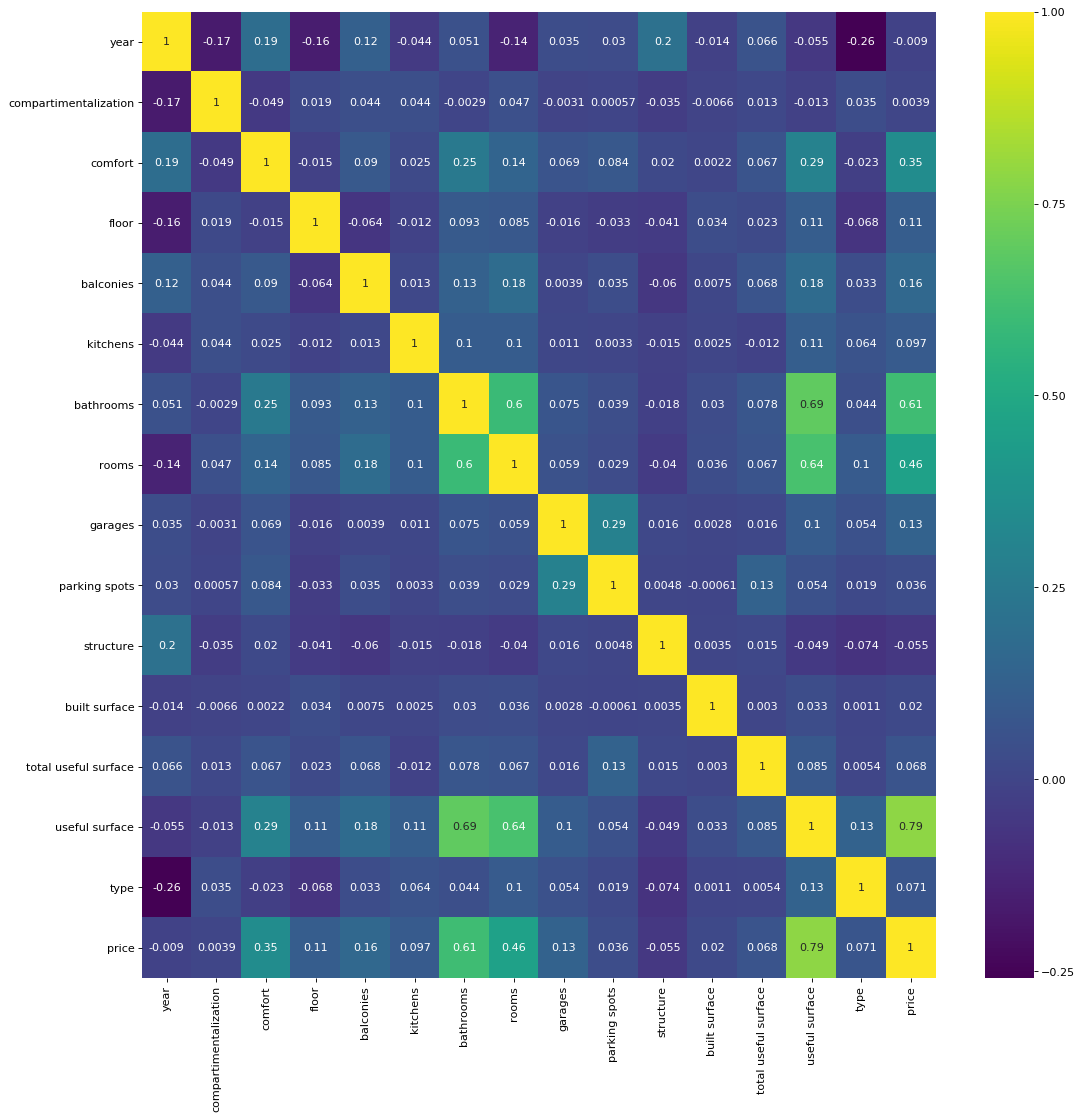

In [53]:
figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), cmap=plt.cm.viridis, annot=True)
plt.show()

# Model creation

In [54]:
# We select only variables linearly correlated with the price|
independent_variables = ['comfort', 'bathrooms', 'rooms', 'useful surface']

In [55]:
# Build and evaluate a model using 5-fold CV
X = np.array(df[independent_variables])
y = np.array(df['price'])

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

models = []

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegressionTF()
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    models.append(model)
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 99821.563663
[Split 1] Score: 74291.550179
[Split 2] Score: 56066.904611
[Split 3] Score: 79041.838378
[Split 4] Score: 66531.343103


In [56]:
lr = LinearRegressionTF()
lr.fit(X, y)

### Analyze the price distributions

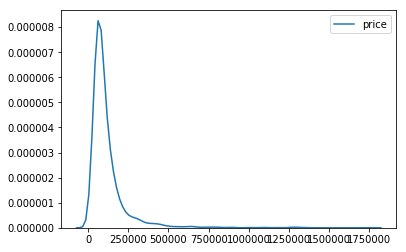

In [57]:
sns.kdeplot(df['price'])

In [58]:
df['price'].describe()

count    3.988000e+03
mean     1.175632e+05
std      1.251538e+05
min      1.000000e+00
25%      5.750000e+04
50%      8.250000e+04
75%      1.295000e+05
max      1.750000e+06
Name: price, dtype: float64

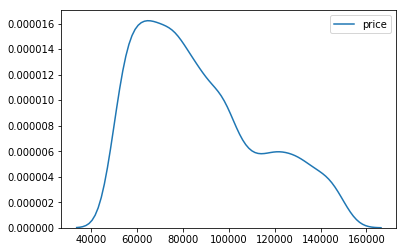

In [59]:
sns.kdeplot(df.loc[df['price'] > 50000].loc[df['price'] < 150000]['price'])

### Make a model using only a 50k-150k price range

In [60]:
X = np.array(df.loc[df['price'] > 50000][df['price'] < 150000][independent_variables])
y = np.array(df.loc[df['price'] > 50000][df['price'] < 150000]['price'])

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

models = []
kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegressionTF()
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    models.append(model)
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 21681.554763
[Split 1] Score: 23708.823820
[Split 2] Score: 21201.621619
[Split 3] Score: 22683.604874
[Split 4] Score: 22609.701340


/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [61]:
model = LinearRegressionTF()
model.fit(X, y)

In [62]:
model.coef_, model.intercept_

(<tf.Tensor: id=472, shape=(4, 1), dtype=float32, numpy=
 array([[4033.9492 ],
        [4263.743  ],
        [ 485.99677],
        [9894.56   ]], dtype=float32)>,
 <tf.Tensor: id=468, shape=(1,), dtype=float32, numpy=array([86846.35], dtype=float32)>)

In [63]:
np.sqrt(mean_squared_error(model.predict(X), y))

22226.469339559157